In [1]:
import numpy as np
import matplotlib.pyplot as plt

# **➤ The Inventory Control Problem**

The inventory control problem is a common problem in operations settings where the task is to ensure a good amount of supply is available in a store subject to (stochastic) demand on each day.

## **➢ Dynamics**
          ➥ The problem setting has the following form: 

1. There is an integer amount of inventory at time $t$, denoted $x(t)$.


2. Each day we may order an integer $u(t)$ units of the product as our control input, where $u(t) \in \{0, \dots, 15\}$.


3. Each day we also observe some i.i.d. stochastic demand $w(t)$ of the product .
  - For simplicity, we'll take $w(t)$ as uniform over the integers $\{0, 1, \dots, 9 \}$.

Hence, the dynamics of the problem may be written:


$$x(t+1) = x(t) + u(t) - w(t) \, $$

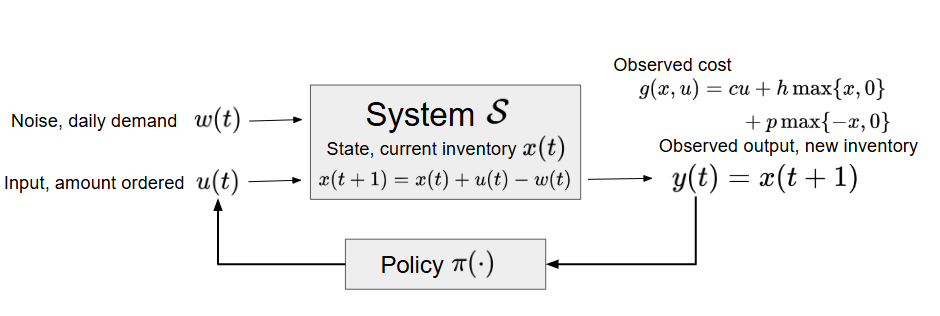

## **➢ Action Space**
         ➥ The action space defines the set of all possible actions that can be taken at any given time. 

In this problem, the action space consists of the number of units to order each day, which can range from 0 to 15 units. This is represented as:
$$ A = \{0, 1, 2, \dots, 15\} $$
 
Additionally, we consider the possible demands for the product, which are uniformly distributed over the integers from 0 to 9. The probabilities of these demands are given by:
 
$$ w \in \{0, 1, 2, \dots, 9\} $$

The probabilities of each demand are:

$$ P(w) = \frac{1}{10} $$

In [2]:
## Action Space
A = np.arange(0, 15 + 1)
possible_w = np.arange(0, 9 + 1)
prob_w = np.ones(len(possible_w)) / len(possible_w)
prob_w = np.arange(len(possible_w)) / (len(possible_w) * len(possible_w) / 2)

print(f'Available Control Actions (A): {A}\n')
print(f'Possible demands (w): {possible_w}\n')
print(f'Probabilities of demands: {prob_w}')

Available Control Actions (A): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

Possible demands (w): [0 1 2 3 4 5 6 7 8 9]

Probabilities of demands: [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18]


## **➢ Costs**

- On each day, we incur a cost due to either having too much product in store (holding costs of $h$ per unit), or not having enough product in store (opportunity cost of $p$ per unit). There may also be a cost to ordering more items (price $c$ for each ordered unit.) That is,


$$ g(x, u) = c u + p \max \{-x, 0\} + h \max\{x, 0\} $$

➥ To begin, let's write the cost function in code:


In [3]:
## Example model parameters
c = 1
p = 6
h = 4

def inventory_control_cost(x, u, c=c, p=p, h=h):
    """
    cost function as defined above
    x: current state
    u: current action
    c: Per-unit ordering cost
    h: holding cost constant
    p: backlogged orders cost
    """
    return c*u + p * max(-x, 0) + h * max(x, 0)

## **➢ Objective**
- The objective for this problem is to **identify the optimal ordering policy**, i.e. given each observation $x(t)$, what is the choice of $u(t)$ that minimizes the overall cost, i.e. we want to find the following:


$$ \min_{u(1), \dots, u(T)} \mathbb{E} \left[\sum_{t = 1}^{T}  g (x(t), u(t)) \right]\, $$


- To simplify the problem, we'll let $T = 10$ be the terminal time period, and focus on identifying the value function at $t=1$, i.e. $V_1(x)$ for $x \in \{ -15, \dots, 15 \}$. We will also be interested in identifying the optimal policy at $t = 1$.

In [4]:
## Terminal Time Period
T = 10 

## x Values for which we want to compute the value function and optimal policy
relevant_X = np.arange(-15, 15 + 1)
relevant_X

array([-15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,
        -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
        11,  12,  13,  14,  15])

## **➢ Approach**
- Our approach will be to use **dynamic programming**, specifically using the **Bellman equations** and the **principle of optimality**. 

➥ That is, we will use $V_T(\cdot)$ to compute $V_{T-1} (\cdot)$, $V_{T-1} (\cdot)$ to compute $V_{T-2}( \cdot)$, and so on, until we can compute $V_1(\cdot)$ .

- **Terminal Condition:**  
       ➥ From the previous video, we know that $V_T(\cdot)$ can be computed as follows:

   $$
   \begin{align*}
   V_T(x) &= \min_{u(T)} \mathbb{E} [g(x, u(T))] \\
   &= \min_{u(T)} \mathbb{E} [c u(T) + p \max \{-x, 0\} + h \max\{x, 0\}] \\
   &= \min_{u(T)} c u(T) + p \max \{-x, 0\} + h \max\{x, 0\} \\
   &= p \max \{-x, 0\} + h \max\{x, 0\} \\
   &= g(x, 0)
   \end{align*}
   $$


- **Bellman Equation:**
       
       ➥ The Bellman Equation then tells us:


   $$
   V_{t}(x) = \min_{u(t)} \mathbb{E} \big[g(x, u(t)) + V_{t+1}(x(t+1))\big] \,
   $$


   ➥ For us, we can take the example of $t = 1$, to see:
   
   $$
   \begin{align*}
   V_{1}(x) &= \min_{u(1)} \mathbb{E} [g(x, u(1)) + V_{2}(x(2))] \\
   &= \min_{u(1)} \mathbb{E} [g(x, u(1)) + V_{2}(x + u(1) - w(1))] \\
   &= \min_{u(1) \in \{ 0, \dots, 15\}} \sum_{w = 0}^{9} \mathbf{P}(w(1) = w) \big[g(x, u(1)) + V_{2}(x + u(1) - w(1)) \big]
   \end{align*}
   $$


➥ So, if we want to compute $V_1(x)$ at $x = 0$, we need to know $V_2(-9)$ through $V_2(15)$. Similarly, to compute $V_2(-9)$, we'll need $V_3(-18)$ through $V_3(4)$.

- **Algorithmic Choice:**  
          ➥ There's two ways we could go about actually computing the value function $V_1(x)$ for the $x$ that we care about. 

   1. We could compute all of the $V_T(\cdot)$ that we will eventually need, and work backwards.
   2. We could use recursion, tell the algorithm that we need $V_1(-15)$ through $V_1(15)$, and let recursive calls to the algorithm compute the remaining value functions that we need.

In the code, we will take a recursive approach. To save time, we will use a nested dictionary to store previously seen computed values of the Value function, for which V[t][x] = $V_t(x)$ 

In [5]:
## Nested dictionary to store previously seen values of the value function
V_cache = {t: {} for t in range(T + 1)}

def compute_value_function(t, x, A=A, T=T, c=c, p=p, h=h, V_cache=V_cache):
    ## If already in cache
    if x in V_cache[t].keys():
        return V_cache[t][x]
    
    ## If at the terminal time period, store in cache and return the terminal cost:
    if (t == T):
        V_cache[t][x] = inventory_control_cost(x, 0)
        return V_cache[t][x]
    
    ## Otherwise, for t < T, we will use the value function at t+1 to get the next best action.
    ## Specifically, we find the action that has the minimum expected value function at t+1
    if(t < T):
        min_v = np.inf
        for u in A:
            individual_terms_in_expectation = []
            for w in possible_w:
                next_state = x + u - w
                individual_terms_in_expectation.append(
                    inventory_control_cost(x, u) + \
                    compute_value_function(t + 1, next_state, A=A, T=T, c=c, p=p, h=h, V_cache=V_cache)
                )
            
            v_u =  prob_w.dot(individual_terms_in_expectation)
            
            if(v_u < min_v):
                min_v = v_u
        V_cache[t][x] = min_v
    return V_cache[t][x]


In [6]:
## Actually compute the V_1 values
V_1 = np.zeros(len(relevant_X))
for idx, x in enumerate(relevant_X):
    V_1[idx] = compute_value_function(1, x, A=A, T=T, c=c, p=p, h=h, V_cache=V_cache)

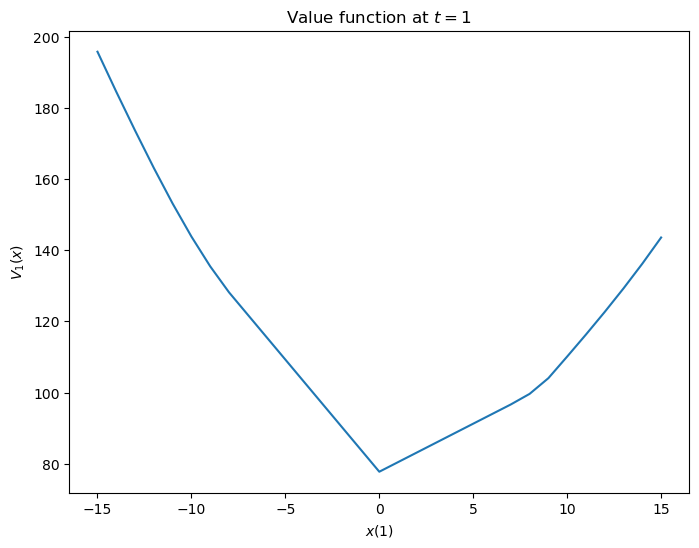

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(relevant_X, V_1)
plt.xlabel("$x(1)$")
plt.ylabel("$V_1(x)$")
plt.title("Value function at $t=1$")
plt.show()

The above code only shows the value function itself. However, we are also interested in knowing the **optimal action**:

$$
\Pi_t(x) = \arg\min_{u(t)} \mathbb{E} \big[g(x(t), u(t)) + V_{t+1}(x(t+1))\big]\\
$$


To compute this, we just need to keep track of the optimal action as we compute the **value function**.

In [8]:
## Nested dictionary to store previously seen values of the value function
VA_cache = {t: {} for t in range(T + 1)}

def compute_value_function_with_action(t, x, A=A, T=T, c=c, p=p, h=h, VA_cache=VA_cache):
    ## If already in cache, return
    if x in VA_cache[t].keys():
        return VA_cache[t][x]
    
    ## If at the terminal time period, store in cache and return the terminal cost + arbitrary action:
    if (t == T):
        VA_cache[t][x] = (inventory_control_cost(x, 0, p=p, h=h), 0)
        return VA_cache[t][x]
    
    ## Otherwise, for t < T, we will use the value function at t+1 to get the next best action.
    ## Specifically, we find the action that has the minimum expected value function at t+1
    if(t < T):
        min_v = np.inf
        opt_u = np.inf
        for u in A:
            individual_terms_in_expectation = []
            for w in possible_w:
                next_state = x + u - w
                individual_terms_in_expectation.append(
                    inventory_control_cost(x, u) + \
                    compute_value_function_with_action(t+1, next_state, VA_cache=VA_cache)[0]
                )
            
            v_u =  prob_w.dot(individual_terms_in_expectation)
            if v_u < min_v:
                min_v = v_u
                opt_u = u
                
        VA_cache[t][x] = (min_v, opt_u)
    return VA_cache[t][x]

In [9]:
V_1 = np.zeros(len(relevant_X))
Pi_1 = np.zeros(len(relevant_X))
for idx, x in enumerate(relevant_X):
    V_1[idx], Pi_1[idx] = compute_value_function_with_action(1, x, A=A, T=T, c=c, p=p, h=h, VA_cache=VA_cache)

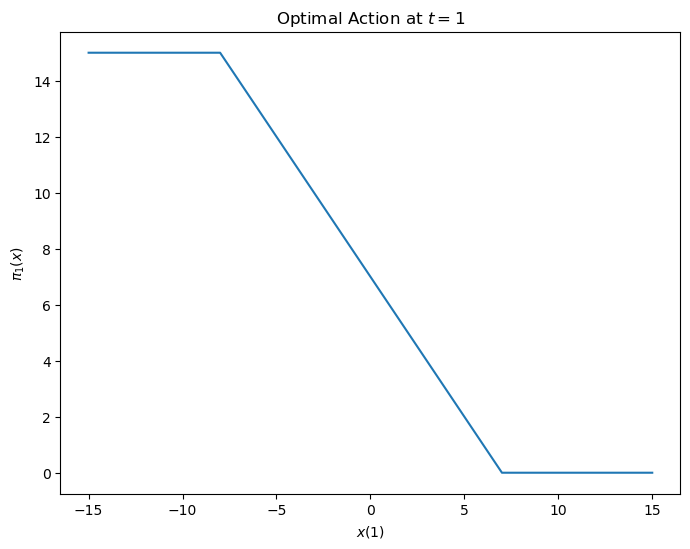

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(relevant_X, Pi_1)
plt.xlabel("$x(1)$")
plt.ylabel("$\pi_1(x)$")
plt.title("Optimal Action at $t=1$")
plt.show()

In [16]:
## value of S to restock to for S policy
print(Pi_1[0 - min(relevant_X)])

7.0
